In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "cell_images\\cell_images\\train"
test_path  = "cell_images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=128, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=128, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
ConvNeXtBase_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtBase(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

ConvNeXtBase_model.add(pretrained_model)

ConvNeXtBase_model.add(Flatten())
ConvNeXtBase_model.add(Dense(128, activation='relu'))
ConvNeXtBase_model.add(Dense(1, activation='sigmoid'))

350926856/350926856 [==============================] - 27s 0us/step


In [11]:
ConvNeXtBase_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 87,697,793
Trainable params: 131,329
Non-trainable params: 87,566,464
_________________________________________________________________


In [12]:
ConvNeXtBase_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=12)

In [14]:
ConvNeXtBase_model.fit(train_image_gen, epochs=60, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/60
195/195 [==============================] - 448s 2s/step - loss: 0.2156 - accuracy: 0.9145 - val_loss: 0.1793 - val_accuracy: 0.9288
Epoch 2/60
195/195 [==============================] - 213s 1s/step - loss: 0.1675 - accuracy: 0.9380 - val_loss: 0.1692 - val_accuracy: 0.9392
Epoch 3/60
195/195 [==============================] - 193s 986ms/step - loss: 0.1554 - accuracy: 0.9430 - val_loss: 0.1643 - val_accuracy: 0.9442
Epoch 4/60
195/195 [==============================] - 197s 1s/step - loss: 0.1539 - accuracy: 0.9445 - val_loss: 0.1521 - val_accuracy: 0.9458
Epoch 5/60
195/195 [==============================] - 201s 1s/step - loss: 0.1493 - accuracy: 0.9452 - val_loss: 0.1525 - val_accuracy: 0.9438
Epoch 6/60
195/195 [==============================] - 198s 1s/step - loss: 0.1418 - accuracy: 0.9486 - val_loss: 0.1540 - val_accuracy: 0.9377
Epoch 7/60
195/195 [==============================] - 192s 986ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.1423 - val_accuracy: 

In [15]:
history = pd.DataFrame(ConvNeXtBase_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.215639,0.914456,0.179313,0.928846
1,0.167488,0.937976,0.169226,0.939231
2,0.155414,0.942984,0.164260,0.944231
3,0.153893,0.944547,0.152084,0.945769
4,0.149276,0.945228,0.152505,0.943846


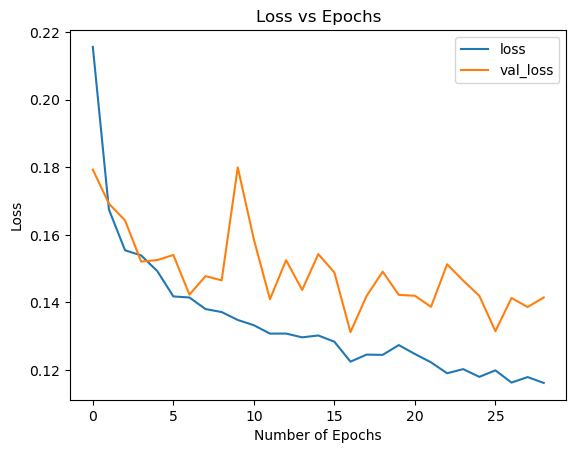

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsConNXtB.png')
plt.show()

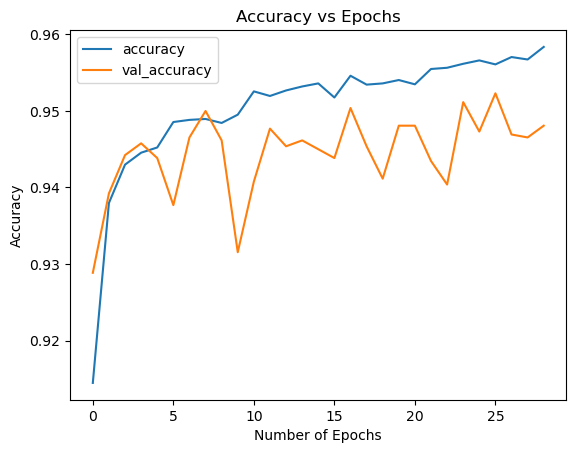

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsConNXtB.png')
plt.show()

In [19]:
predictions = ConvNeXtBase_model.predict(test_image_gen)

21/21 [==============================] - 27s 908ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1217,   83],
       [  47, 1253]], dtype=int64)

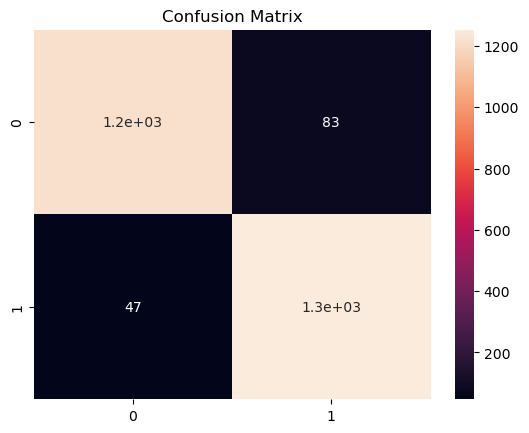

In [23]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapConNXtB.png')
plt.show()

In [24]:
ConvNeXtBase_model.save("MalariaPredictionsConNXtB.h5")